In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [183]:
# FUNÇÃO CRIADA PARA CRIAÇÃO DOS GRÁFICOS

def reg_graph (x, y, data,sct_size=None,s=10,title='', legend_visibility=True, legend_title='', xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25):
    # x = eixo x do gráfico
    # y = eixo y do gráfico
    # data = dataframe origem dos dados que representam x e y
    # sct_size = tamanho do scatter no gráfico BASEADO em uma coluna do dataframe
    # s = tamanho do scatter no gráfico BASEADO em um NUMERO
    # title = título do gráfico
    # legend_visibility = visibilidade da legenda
    # legend_title = título da legenda
    # xlabel = título do eixo x
    # ylabel = titulo do eixo y
    # offset_txt_x = deslocamento do texto da função no eixo x
    # offset_txt_y = deslocamento do texto da função no eixo y

    sns.set_style('darkgrid')

    f, ax = plt.subplots(1,figsize=(8, 5))

    sns.scatterplot(x=data[x], y=data[y], data=data,size=sct_size,s=s)

    rng = np.random.default_rng(1234) #seed para valores aleatórios
    lr = LinearRegression(fit_intercept=fit_intercept)
    fitted_reg = lr.fit(data[[x]],data[[y]])

    if not fit_intercept:
        fitted_reg.intercept_ = [fitted_reg.intercept_] # Prevenindo erros

    r2_score = fitted_reg.score(data[[x]],data[[y]]) # R² Score
    x_reg_line = rng.uniform(data[x].min(), data[x].max(), size=100) # gerando valores entre os valores do scatterplot para criar a reta
    y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada

    if reg_from_start:

        if (data[x].min() < 0) and (abs(data[x].min()) > data[y].max()): # Para valores data[x] negativos

            x_reg_line = rng.uniform(data[x].min() * 2 , 0, size=1000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[y].min() < 0) and (abs(data[y].min()) > data[x].max()): # Para valores data[y] negativos

            x_reg_line = rng.uniform(data[y].min() * 2 , 0, size=1000) # gerando valores entre os valores do scatterplot para criar a reta, partindo do 0

        elif (data[x].max() > data[y].max()):

            x_reg_line = rng.uniform(0, data[x].max() * 2, size=1000)

        else:

            x_reg_line = rng.uniform(0, data[y].max() * 2, size=1000)

        y_reg_line = x_reg_line * fitted_reg.coef_ + fitted_reg.intercept_[0] # função y=ax + b para representar a reta criada


    text_coord_x = data[x].max() - data[x].max() * offset_txt_x  #eixo x do texto


    plt.text(text_coord_x, offset_txt_y, f'Y={round(fitted_reg.coef_[0][0],4)}x + {round(fitted_reg.intercept_[0],4)}',fontsize=12, ha='center', va='center',color='blue') #Texto da reta Azul
    plt.text(text_coord_x, offset_txt_y - (offset_txt_y*0.3), f'R²:{round(r2_score,4)}', fontsize=12, ha='center', va='center',color='blue') # Texto r²


    ax.set_ylim((0, (data[y].max() + (data[y].max()/2)))) # tamanho limite do plot no eixo y
    ax.set_xlim((0, data[x].max() + data[x].max()/2)) # tamanho limite do plot no eixo x
    ax.plot(x_reg_line,y_reg_line[0]) #reta de regressão

    if ativar_grafico_yx:
        y_x = rng.uniform(0, 1000, size=1000) # gerando 100 valores aleatórios
        ax.plot(y_x,y_x, 'k--') # reta y=x

    if legend_title:
        plt.legend(title=legend_title,loc='upper left').set_visible(legend_visibility) #legenda no canto superior esquerdo

    plt.title(title) # Título do gráfico
    plt.xlabel(xlabel) #Título do eixo X
    plt.ylabel(ylabel) #Título do eixo y
    plt.tight_layout() #Redimensionar melhor o gráfico
    plt.show() #Mostrar o gráfico

In [199]:
ameriflux = pd.read_csv('./DadosNPPTorre/ameriflux-santarem-dados.csv') # Dados da AMERIFLUX
modis = pd.read_csv('./DadosNPPSatelite/Npp_500m.csv',header=None)
ameriflux = ameriflux.drop(['Time','Date'],axis=1)

ameriflux.fillna(np.nan)

# Função para remover todos os pontos, exceto o último, e converter para número
def remove_pontos_e_converter(valor):
    partes = valor.split('.')
    if len(partes) > 1:
        partes[:-1] = [''.join(partes[:-1])]
    valor_sem_pontos = '.'.join(partes)
    return float(valor_sem_pontos)
#ex: 100.000.000 -> 100000.000


# Aplique a função à coluna 'Valor'
ameriflux['NPP'] = ameriflux['NPP'].apply(remove_pontos_e_converter)
ameriflux['NPP'] = ameriflux['NPP'].apply(lambda x: x /(10**6)) # umolCO2 m-2 y-1 / 10 ** 6 = molCO2 m-2 y-1
ameriflux['NPP'] *= (12/44)  # molCO2 m-2 y-1  * gC/mol = gC m-2 y-1  # Relação massaC/massaCO2 pega do chatgpt, para pegar a massa excluisamente do C na equação
ameriflux['NPP'] /= (10**3)  # gC m-2 y-1 / 10**3 = kgC m-2 y-1

ameriflux_npp = ameriflux.groupby(by='Year')['NPP'].mean() 

ameriflux_npp = ameriflux_npp.reset_index().drop('Year',axis=1)

ameriflux_npp *= -1 # Multipliquei por -1 para lidar apenas com valores positivos

ameriflux_npp

,NPP
0,1391.026145
1,1578.385090
2,1553.698680


In [185]:
# profile = ProfileReport(ameriflux, tsmode=True,sortby="Year",title='Profile Report Ameriflux')
# profile.to_file("your_report.html")

In [200]:
modis_data = modis.loc[modis[2].isin(['A2009001','A2010001','A2011001'])].copy() # Dados de NPP nos anos de 2009, 2010 e 2011


modis_data = modis_data.drop([0,1,3,4],axis=1).reset_index().drop('index',axis=1) # Retirando colunas com informações não relevantes e restabelecendo o dataframe a partir de um index 0 nas 2 linhas


modis_data.columns = range(len(modis_data.columns.to_list())) # Reiniciando o index a partir do 0 para as colunas 


modis_data.set_index(0,inplace=True) # Colocando o "Acquisition Date [ A (YYYYDDD) ]"  como index para legibilidade do dataframe

modis_npp_mean = modis_data.mean(axis=1) # Média de NPP nesses anos 

modis_npp_mean = modis_npp_mean.apply(lambda x:x/10)
modis_npp_mean

0
A2009001    1204.458131
A2010001    1183.960900
A2011001    1227.250865
dtype: float64

In [201]:
npp_dataframe = {
    'ameriflux_NPP':ameriflux_npp.values.reshape(1,-1)[0],
    'modis_NPP':modis_npp_mean.values
}
npp_dataframe = pd.DataFrame(npp_dataframe)
npp_dataframe
# os valores de npp do modis não estão "escalados", 
# apesar do cálculo de npp da torre estar correto, ele difere dos de satélite quando este está escalado e no mesmo formato do mapa

,ameriflux_NPP,modis_NPP
0,1391.026145,1204.458131
1,1578.385090,1183.960900
2,1553.698680,1227.250865


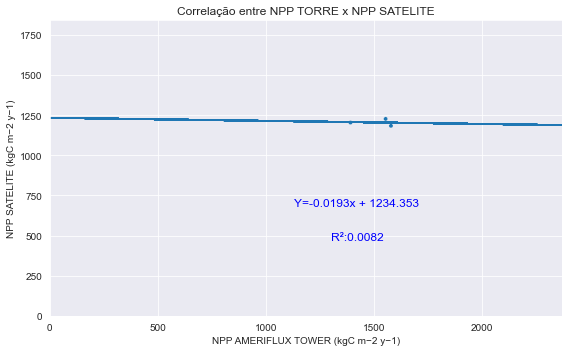

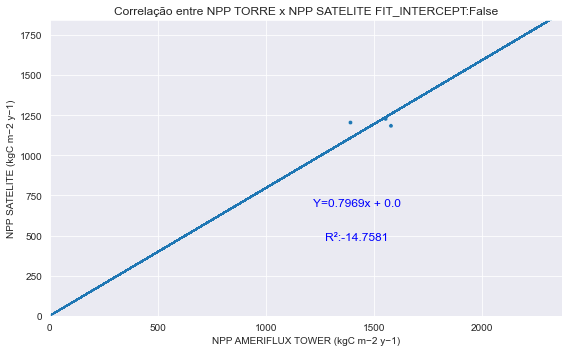

In [203]:
#(x, y, data,sct_size=10, title='', legend_visibility=True, legend_title=None, xlabel='', ylabel='', fit_intercept=True, ativar_grafico_yx=False,reg_from_start=False, offset_txt_x=0.15,offset_txt_y=2.25)
eixo_x = 'ameriflux_NPP'
eixo_y = 'modis_NPP'
data = npp_dataframe
xlabel = "NPP AMERIFLUX TOWER (kgC m−2 y−1)"
ylabel = "NPP SATELITE (kgC m−2 y−1)"
title = "Correlação entre NPP TORRE x NPP SATELITE"

reg_graph(eixo_x,eixo_y,sct_size=30,data=data,xlabel=xlabel,ylabel=ylabel,title=title,legend_visibility=False,reg_from_start=True,offset_txt_x=0.1,offset_txt_y=700)

reg_graph(eixo_x,eixo_y,data=data,xlabel=xlabel,ylabel=ylabel,title=title + ' FIT_INTERCEPT:False',fit_intercept=False,reg_from_start=True,legend_visibility=False,offset_txt_x=0.1,offset_txt_y=700)